#### 해외포함영화(평점) xg

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

df = pd.read_csv('해외포함영화(평점).csv')

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

df = df.dropna(subset=['release_date'])

df = df[(df['vote_average'] >= 0) & (df['release_date'] < pd.Timestamp('2026-01-01'))]

print("필터링 후 데이터 수:", len(df))

df['release_year'] = df['release_date'].dt.year
df['release_month'] = df['release_date'].dt.month

def extract_main_genre(genres):
    if pd.isna(genres) or genres == '':
        return 'Unknown'
    return genres.split(',')[0].strip()

df['main_genre'] = df['genres'].apply(extract_main_genre)

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
genre_encoded = encoder.fit_transform(df[['main_genre']])
genre_df = pd.DataFrame(
    genre_encoded, 
    columns=encoder.get_feature_names_out(['main_genre'])
)


df = pd.concat([df.reset_index(drop=True), genre_df], axis=1)

feature_cols = ['release_year', 'release_month'] + list(genre_df.columns) + ['vote_count']
X = df[feature_cols].copy()
y = df['vote_average']

scaler = MinMaxScaler()
X[['release_year', 'release_month', 'vote_count']] = scaler.fit_transform(X[['release_year', 'release_month', 'vote_count']])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


필터링 후 데이터 수: 9997
RMSE: 1.0368
MAE: 0.3391


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

params = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=params,
    scoring='neg_root_mean_squared_error',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 성능 RMSE:", -grid_search.best_score_)


Fitting 3 folds for each of 243 candidates, totalling 729 fits
최적 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
최고 성능 RMSE: 0.9207058578539916


In [42]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"튜닝 후 RMSE: {rmse:.4f}")
print(f"튜닝 후 MAE: {mae:.4f}")


튜닝 후 RMSE: 1.0006
튜닝 후 MAE: 0.3406


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
import pandas as pd
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

data = fetch_california_housing()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("최적 하이퍼파라미터:", grid_search.best_params_)
print("최고 성능 RMSE (CV 평균):", -grid_search.best_score_)

best_model = XGBRegressor(**grid_search.best_params_, random_state=42)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)  
mae = mean_absolute_error(y_test, y_pred)

print(f"튜닝 후 테스트셋 RMSE: {rmse:.4f}")
print(f"튜닝 후 테스트셋 MAE: {mae:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
최적 하이퍼파라미터: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
최고 성능 RMSE (CV 평균): 0.460679974155666
튜닝 후 테스트셋 RMSE: 0.4488
튜닝 후 테스트셋 MAE: 0.2916


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


y_test 길이: 2000
y_pred 길이: 4128


C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 54217 (\N{HANGUL SYLLABLE PYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 51216 (\N{HANGUL SYLLABLE JEOM}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_23940\1019316778.py:30: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from f

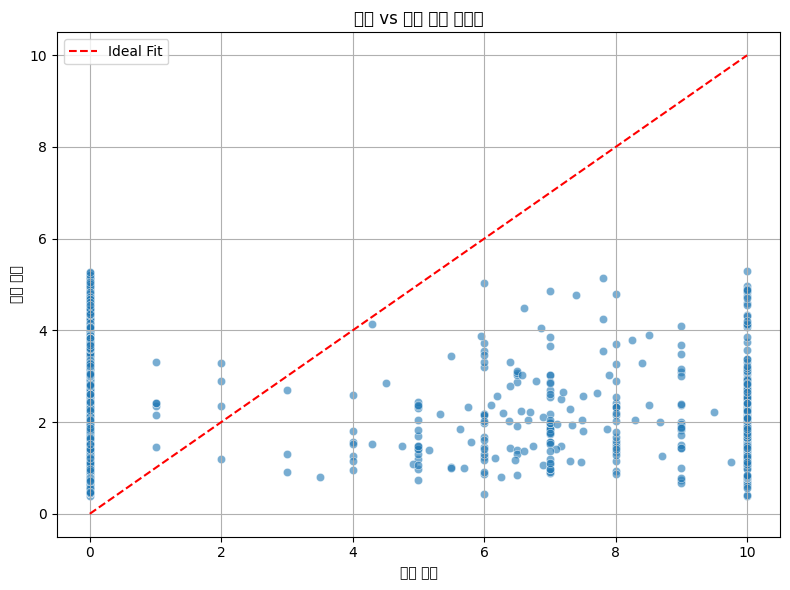

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

print("y_test 길이:", len(y_test))
print("y_pred 길이:", len(y_pred))

y_test_array = np.array(y_test)
y_pred_array = np.array(y_pred)

min_len = min(len(y_test_array), len(y_pred_array))
y_test_array = y_test_array[:min_len]
y_pred_array = y_pred_array[:min_len]

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test_array, y=y_pred_array, alpha=0.6)
plt.plot([y_test_array.min(), y_test_array.max()],
         [y_test_array.min(), y_test_array.max()],
         color='red', linestyle='--', label='Ideal Fit')

plt.xlabel('실제 평점')
plt.ylabel('예측 평점')
plt.title('실제 vs 예측 평점 산점도')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [50]:
print(len(y_test_array))   # 예: 2000
print(len(y_pred_array))   # 예: 4128 ← 이게 문제!


2000
4128


In [52]:
print(y_test.min(), y_test.max())
print(y_pred.min(), y_pred.max())


0.0 10.0
0.37342876 5.2938857


#### 박스오피스 관객수 예측

In [55]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

df = pd.read_csv("kobis_KOREAN_movies_202101_202507_with_boxoffice.csv") 

df = df.dropna(subset=['audiAcc', 'openDt', 'targetDt', 'repGenreNm', 'directors', 'prdtYear', 'nationAlt'])

df['openDt'] = pd.to_datetime(df['openDt'], errors='coerce')
df['targetDt'] = pd.to_datetime(df['targetDt'], errors='coerce')

df['open_year'] = df['openDt'].dt.year
df['open_month'] = df['openDt'].dt.month
df['open_day'] = df['openDt'].dt.day

df['target_year'] = df['targetDt'].dt.year
df['target_month'] = df['targetDt'].dt.month
df['target_day'] = df['targetDt'].dt.day

df = df.drop(['movieCd', 'movieNm', 'openDt', 'targetDt'], axis=1)

categorical_cols = ['repGenreNm', 'directors', 'nationAlt', 'watchGradeNm']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')  

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])

encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

df = df.drop(categorical_cols, axis=1).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

X = df.drop('audiAcc', axis=1)
y = df['audiAcc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 67684.9619
MAE: 11498.3524


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [58]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv("kobis_KOREAN_movies_202101_202507_with_boxoffice.csv") 

categorical_cols = ['repGenreNm', 'directors', 'nationAlt', 'watchGradeNm']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')


df = df[df['audiAcc'] > 0] 
y = np.log1p(df['audiAcc'])

X = df[categorical_cols + ['prdtYear']]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(X[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

encoded_df['prdtYear'] = X['prdtYear'].values

X_train, X_test, y_train, y_test = train_test_split(encoded_df, y, test_size=0.3, random_state=42)

model = XGBRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_test_exp = np.expm1(y_test)
y_pred_exp = np.expm1(y_pred)

rmse = mean_squared_error(y_test_exp, y_pred_exp, squared=False)
mae = mean_absolute_error(y_test_exp, y_pred_exp)

print(f"RMSE (복원 후): {rmse:.4f}")
print(f"MAE (복원 후): {mae:.4f}")

RMSE (복원 후): 1399812.6258
MAE (복원 후): 493839.8703


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb

df = pd.read_csv("kobis_KOREAN_movies_202101_202507_with_boxoffice.csv") 

df = df.dropna(subset=['audiAcc', 'openDt', 'targetDt', 'repGenreNm', 'directors', 'prdtYear', 'nationAlt'])
df['openDt'] = pd.to_datetime(df['openDt'], errors='coerce')
df['targetDt'] = pd.to_datetime(df['targetDt'], errors='coerce')

df['open_year'] = df['openDt'].dt.year
df['open_month'] = df['openDt'].dt.month
df['open_day'] = df['openDt'].dt.day
df['target_year'] = df['targetDt'].dt.year
df['target_month'] = df['targetDt'].dt.month
df['target_day'] = df['targetDt'].dt.day

df = df.drop(['movieCd', 'movieNm', 'openDt', 'targetDt'], axis=1)

categorical_cols = ['repGenreNm', 'directors', 'nationAlt', 'watchGradeNm']
df[categorical_cols] = df[categorical_cols].fillna('Unknown')

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = encoder.fit_transform(df[categorical_cols])
encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out(categorical_cols))

df = df.drop(categorical_cols, axis=1).reset_index(drop=True)
df = pd.concat([df, encoded_df], axis=1)

X = df.drop('audiAcc', axis=1)
y = df['audiAcc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',  
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print(f"최적 하이퍼파라미터: {grid_search.best_params_}")
print(f"최고 교차검증 RMSE: {-grid_search.best_score_:.4f}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"튜닝 후 테스트셋 RMSE: {rmse:.4f}")
print(f"튜닝 후 테스트셋 MAE: {mae:.4f}")


Fitting 3 folds for each of 243 candidates, totalling 729 fits
최적 하이퍼파라미터: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
최고 교차검증 RMSE: 87764.1526
튜닝 후 테스트셋 RMSE: 20759.0005
튜닝 후 테스트셋 MAE: 4272.3407


c:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


C:\Users\USER\AppData\Local\Temp\ipykernel_23940\3385933845.py:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
c:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44288 (\N{HANGUL SYLLABLE GWAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\USER\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 44061 (\N{HANGUL SYLLABLE GAEG}) missing from font(

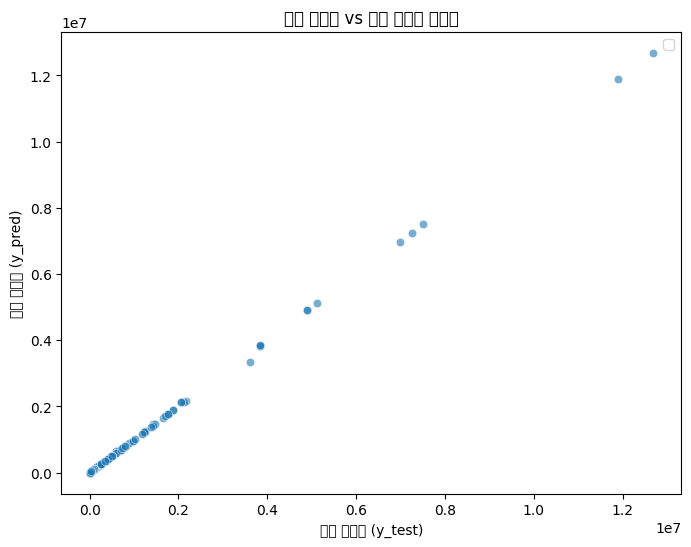

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6)
#plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('실제 관객수 (y_test)')
plt.ylabel('예측 관객수 (y_pred)')
plt.title('실제 관객수 vs 예측 관객수 산점도')
plt.legend()
plt.show()